In [16]:
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import yfinance as yf
import datetime
from datetime import timedelta

# Fetching Information

First we will fetch all the finantial information regarding the stock whose price we will attempt to predict. Then, we will keep only the close price for each day, and we will graph this. Lastly, we want to train out newral network with about 80% of our available data, so we will calculate how many registers this is.

In [107]:
AAPL_stock_information = yf.download('^GSPC', start = '1960-07-15', end = '2020-07-14') # Fetching apple information
AAPL_stock_information.sort_values('Date')
AAPL_stock_information.dropna()
print(AAPL_stock_information.head())
AAPL_stock_information.shape

[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
1960-07-15  56.049999  56.049999  56.049999  56.049999  56.049999  2140000
1960-07-18  55.700001  55.700001  55.700001  55.700001  55.700001  2350000
1960-07-19  55.700001  55.700001  55.700001  55.700001  55.700001  2490000
1960-07-20  55.610001  55.610001  55.610001  55.610001  55.610001  2370000
1960-07-21  55.099998  55.099998  55.099998  55.099998  55.099998  2510000


(15100, 6)

<AxesSubplot:title={'center':'Historic close price for AAPL'}, xlabel='Date', ylabel='Close Price USD ($)'>

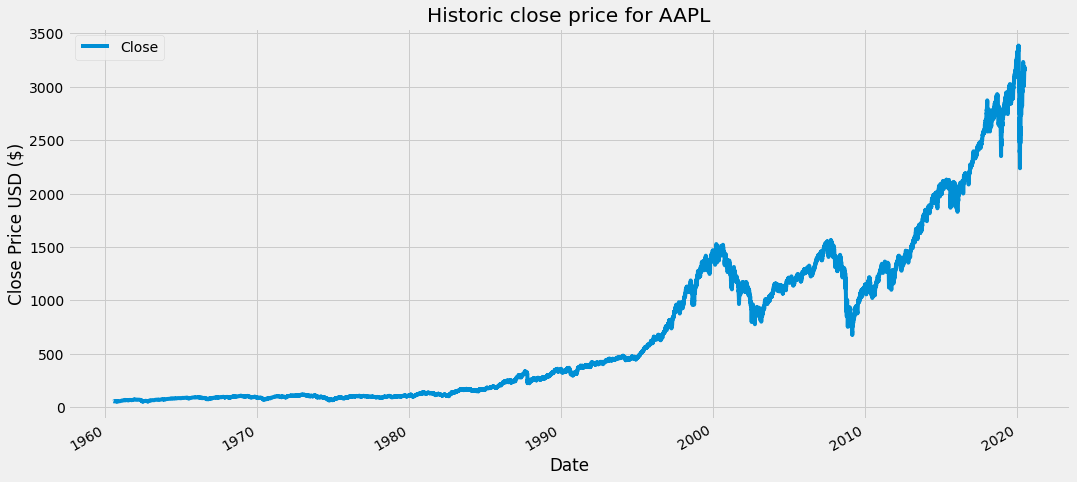

In [108]:
AAPL_close_price = AAPL_stock_information.filter(['Close']) # Droppping everything that isn't close price
AAPL_close_price.plot(title = 'Historic close price for AAPL', figsize=(16,8), xlabel = 'Date', ylabel = 'Close Price USD ($)') # Graphing

In [109]:
training_data_len = math.ceil( AAPL_close_price.shape[0] *.9) # Calculates number of training registers
training_data_len

13590

# Scaling

Now we will scale oll of our closing prices on a scale of 0 to 1, inclusive. This is generally a good practice when it comes to neural networks. We will use the MinMax method, which goes as follows:

$ X_{new} = \frac{X - X_{min}}{X_{max}-X_{min}} $

For time's sake, we will use the preimplemented MinMaxScaler package of the python *sklean* library. But, before we do this, we must make one last trasformation. Up until now we have been storing our closing prices in a *pandas* dataframe, but the pre-imlemented MinMaxScaler requires an array input, probably because the operations required to find the largest and smallest numbers iun this data structure are long, therefore we will transform this *pandas* dataset into a *numpy* array, in which theses operations can be done faster.

In [110]:
array_of_closing_values = AAPL_close_price.values # Transfor the dataframe into an array

scaler = MinMaxScaler(feature_range=(0, 1)) # Instanciate a MinMaxScaler with a [0,1] range
scaled_close_prices = scaler.fit_transform(array_of_closing_values) # Pass the data to the scaler, for it to scale it :)

scaled_close_prices

array([[0.00115479],
       [0.00104981],
       [0.00104981],
       ...,
       [0.92978303],
       [0.9396782 ],
       [0.93073383]])

# Creating the Training Data

For this problem in particular we will create 2 data sub-sets. The first one we will call independent train or $x train$ and the decond one we will call dependant train, or $y train$. The independant train will have sets of 60 days worth of information, and the dependant train will store the closing price information for the day after the ones stored in the $x train$ position with the same index.

In [111]:
train_data = scaled_close_prices[0:training_data_len , : ] # Selects from the scaled prices the number of rows defined as training_data_len
print(train_data)

# Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for row in range(60, len(train_data)):
    x_train.append(train_data[row-60:row,0])
    y_train.append(train_data[row,0])
    
# Turn the x and y trains into arrays, because the neural network trainer only takes 3-dimentional arrays
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

[[0.00115479]
 [0.00104981]
 [0.00104981]
 ...
 [0.57363791]
 [0.57450472]
 [0.5773632 ]]


# Building the Model

In [112]:
#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=1)

13530/13530 [==============================] - 398s 29ms/step - loss: 1.1479e-04


In [113]:
test_data = scaled_close_prices[training_data_len - 60: , : ] # We declare the test data to be the last 20% of out total information

#Create the x_test and y_test data sets
x_test = []
y_test =  array_of_closing_values[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
x_test

array([[[0.54369443],
        [0.54580605],
        [0.54810363],
        ...,
        [0.57363791],
        [0.57450472],
        [0.5773632 ]],

       [[0.54580605],
        [0.54810363],
        [0.54685585],
        ...,
        [0.57450472],
        [0.5773632 ],
        [0.57621743]],

       [[0.54810363],
        [0.54685585],
        [0.54782166],
        ...,
        [0.5773632 ],
        [0.57621743],
        [0.57870394]],

       ...,

       [[0.83800301],
        [0.8191965 ],
        [0.82405259],
        ...,
        [0.93808247],
        [0.92776441],
        [0.93514901]],

       [[0.8191965 ],
        [0.82405259],
        [0.84655143],
        ...,
        [0.92776441],
        [0.93514901],
        [0.92978303]],

       [[0.82405259],
        [0.84655143],
        [0.83113424],
        ...,
        [0.93514901],
        [0.92978303],
        [0.9396782 ]]])

In [114]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions) # Undo scaling

<ipython-input-115-a2bb6d1fc640>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


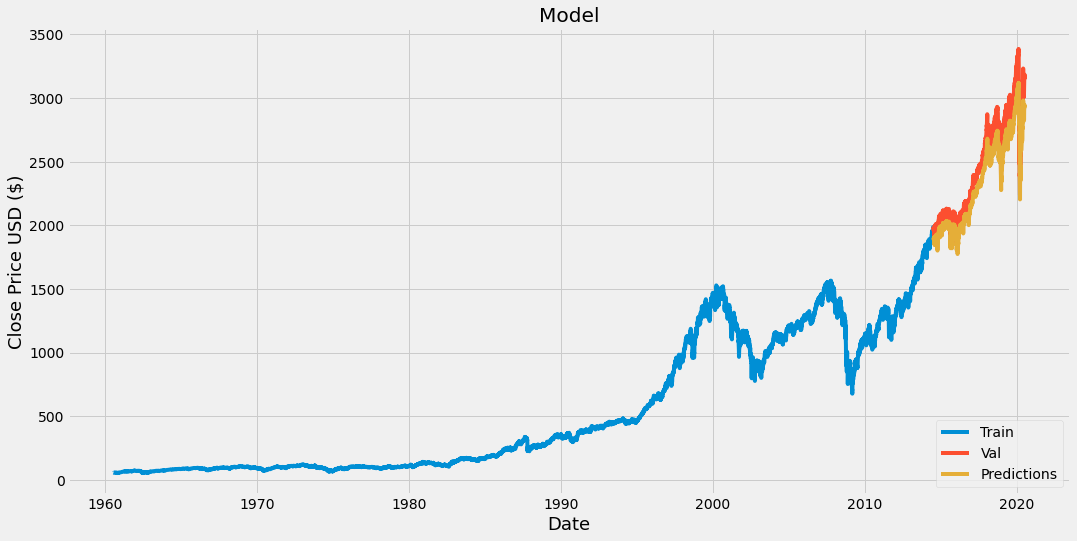

In [115]:
#Plot/Create the data for the graph
train = AAPL_close_price[:training_data_len]
valid = AAPL_close_price[training_data_len:]
valid['Predictions'] = predictions

#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [116]:
pd.set_option('display.max_rows', 10)
valid[['Close', 'Predictions']]

,Close,Predictions
Date,,
2014-07-15,1973.280029,1892.841797
2014-07-16,1981.569946,1893.900635
2014-07-17,1958.119995,1898.239990
2014-07-18,1978.219971,1886.670410
2014-07-21,1973.630005,1891.877075
...,...,...
2020-07-07,3145.320068,2948.750977
2020-07-08,3169.939941,2934.333252
2020-07-09,3152.050049,2938.117676


In [121]:
array_of_predictions = valid[['Predictions']].values
array_of_real_prices = valid[['Close']].values

success = 0
failure = 0

for i in range (array_of_predictions.shape[0] - 1):
    if ((array_of_predictions[i + 1] < array_of_predictions[i]) and (array_of_real_prices[i+1] < array_of_real_prices[i])):
        success = success + 1
    elif ((array_of_predictions[i+1] > array_of_predictions[i]) and (array_of_real_prices[i+1] > array_of_real_prices[i])):
        success = success + 1
    elif ((array_of_predictions[i+1] < array_of_predictions[i]) and (array_of_real_prices[i+1] > array_of_real_prices[i])):
        failure = failure + 1
        print(i)
    elif ((array_of_predictions[i+1] > array_of_predictions[i]) and (array_of_real_prices[i+1] < array_of_real_prices[i])):
        failure = failure + 1
        print(i)
        
print(f'Success = {success}, Failure = {failure}, Success rate = {success/(success+failure) * 100}')
array_of_real_prices

1
2
3
7
8
10
13
14
15
17
19
22
27
28
31
32
33
34
36
37
39
41
43
46
47
49
50
51
52
53
55
56
57
58
59
60
63
65
66
69
72
74
77
78
79
84
89
93
95
97
99
101
104
108
113
114
116
121
123
124
128
132
136
137
138
140
142
144
145
149
150
151
152
154
155
157
158
160
162
165
166
168
170
171
172
173
176
178
180
182
186
187
188
189
190
191
192
196
197
198
200
202
204
206
207
209
212
213
214
215
217
218
219
220
222
223
226
227
229
231
234
235
237
241
242
243
244
245
246
247
248
251
255
260
263
266
267
269
270
271
273
275
276
281
284
286
287
288
289
290
291
293
294
296
297
298
304
305
309
314
316
319
321
323
324
325
326
327
328
330
334
338
339
341
343
344
346
347
348
349
351
352
353
355
357
358
360
362
363
365
366
367
368
371
375
376
377
378
379
380
382
383
384
385
386
387
388
389
390
391
392
393
398
401
402
403
404
405
406
407
408
409
414
415
416
418
419
420
424
427
430
432
434
435
436
438
441
442
445
446
448
450
452
453
456
459
462
463
464
466
467
470
472
473
475
476
479
480
484
485
486
488
489
490


array([[1973.2800293 ],
       [1981.56994629],
       [1958.11999512],
       ...,
       [3152.05004883],
       [3185.04003906],
       [3155.2199707 ]])